# Loading Libraries

In [190]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

# Loading CIFAR-10 Dataset

In [191]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Getting Number of classes and defining class labels

In [192]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Reshaping and Normalizing the data

Convert class vectors to binary class matrices:

In [193]:
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

Normalizing the data into the range between -1 and 1, because Generator is using tanh as activation function:

In [194]:
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

# Define Model

## Generator

Define Generator Function: here we merge the input noise z which has 100 dimension and then merge it with class labels and give it to the generator network as conditional input. generator is composed of one fully connected layer and 4 transposed convolution layers, using LeakyRelu as activation function for each layer except for last layer that uses tanh. and we also use Batch Normalization in generator network

In [223]:
def build_generator(z, labels):
  
  # merging noise with the conditional information which are class labels
  merged_layer = Concatenate()([z, labels])

  # FC:
  generator = Dense(2*2*512, activation='relu')(merged_layer)
  generator = BatchNormalization(momentum=0.9)(generator)
  generator = LeakyReLU(alpha=0.1)(generator)
  generator = Reshape((2, 2, 512))(generator)

  # # Conv 1:
  generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
  generator = BatchNormalization(momentum=0.9)(generator)
  generator = LeakyReLU(alpha=0.1)(generator)

  # Conv 2:
  generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
  generator = BatchNormalization(momentum=0.9)(generator)
  generator = LeakyReLU(alpha=0.1)(generator)

  # Conv 3:
  generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
  generator = BatchNormalization(momentum=0.9)(generator)
  generator = LeakyReLU(alpha=0.1)(generator)

  # Conv 4:
  generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

  generator = Model(inputs=[z, labels], outputs=generator, name='generator')

  return generator

Defining inputs of build_generator function wich are the noise and labels shape:

In [196]:
# latent space dimension
z = Input(shape=(100,))

# classes
labels = Input(shape=(10,))

Call build_generator function:

In [197]:
generator = build_generator(z, labels)

Visualization of Generator model:

In [198]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 110)          0           input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 2048)         227328      concatenate_17[0][0]     

## Discriminator

Define Discriminator function: Here we define the discriminator network 7 layers. The first 4 layers are convolution layers using LeakyRelu activation function and also Batch Normalization. Then we use a fully connected layer to flatten the data. Then we merge the output of discriminator and class labels and make a conditional input and give it to a Dense layer with Relu activation. Finally we define a Dense layer with sigmoid activation to get the output of the network witch is a probability that the image is real or generated by generator network

In [222]:
def build_discriminator(input_image_shape):

  # Conv 1:
  discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image_shape)
  discriminator = BatchNormalization(momentum=0.9)(discriminator)
  discriminator = LeakyReLU(alpha=0.1)(discriminator)

  # Conv 2:
  discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
  discriminator = BatchNormalization(momentum=0.9)(discriminator)
  discriminator = LeakyReLU(alpha=0.1)(discriminator)

  # Conv 3: 
  discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
  discriminator = BatchNormalization(momentum=0.9)(discriminator)
  discriminator = LeakyReLU(alpha=0.1)(discriminator)

  # Conv 4: 
  discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
  discriminator = BatchNormalization(momentum=0.9)(discriminator)
  discriminator = LeakyReLU(alpha=0.1)(discriminator)

  # FC
  discriminator = Flatten()(discriminator)

  # Concatenate 
  merged_layer = Concatenate()([discriminator, labels])
  discriminator = Dense(512, activation='relu')(merged_layer)
      
  # Output
  discriminator = Dense(1, activation='sigmoid')(discriminator)

  discriminator = Model(inputs=[input_image_shape, labels], outputs=discriminator, name='discriminator')

  return discriminator

Defining input of build_discriminator function wich is the shape of input images:

In [200]:
input_image_shape = Input(shape=(X_train[0].shape))

Call build_discriminator function:

In [201]:
discriminator = build_discriminator(input_image_shape)

Visualization of Discriminator model:

In [202]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 16, 16, 64)   4864        input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 16, 16, 64)   256         conv2d_33[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_69 (LeakyReLU)      (None, 16, 16, 64)   0           batch_normalization_69[0][0]     
______________________________________________________________________________________

# Compile model

## Compile Discriminator Model

In [203]:
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## Defining Combined network of Generator and Discriminator nets

First we give noise z and labels as input of generator and generate fake image. Then we give the fake image generated by generator and the class labels to the Discriminator and check its validity. In fact the Discriminator gives us the probability that this image is fake or real. Then we define a combined model called d_g and give the conditional data z concatenated with class labels and the validity which is the Discriminator output

In [204]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

## Compile Combined Network

In [205]:
d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

Visualization of Combined model:

In [206]:
d_g.summary()

Model: "adversarial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]        

# Fit Model

First we seperate input data to batches with size of 32. Then we start training. For each epoch, we loop over all data batches and for each batch we do the followings:
1. We concatenate the batch(real samples) and its real labels and consider real*(1 - smooth) as y vector(target), then give these data to the discriminator and train it on this data and compute discriminator loss for real data
2. We generate noise z which is a 100 dimension vector with random normal data, then we generate random labels and concatenate z and random labels and give this data to generator and generate a fake data. Then we train discriminator with this fake data and the fake target which is zero vector called fake and compute the discriminator loss for fake data
3. Then we compute the discriminator loss which is the average of discriminator loss for fake and real data
4. Finally we again generate a normal noise z and concatenate it with random class labels and give this data and its target witch is a vector of ones to the combined d_g net and train this network on this batch and compute d_g loss
5. After training network on all batches in each epoch, we concatenate a 100 dimensional noise z and random class labels and give this data to generator and generate 10*10 samples

epoch = 1/30, d_loss=0.641, g_loss=3.611                                                                                                     


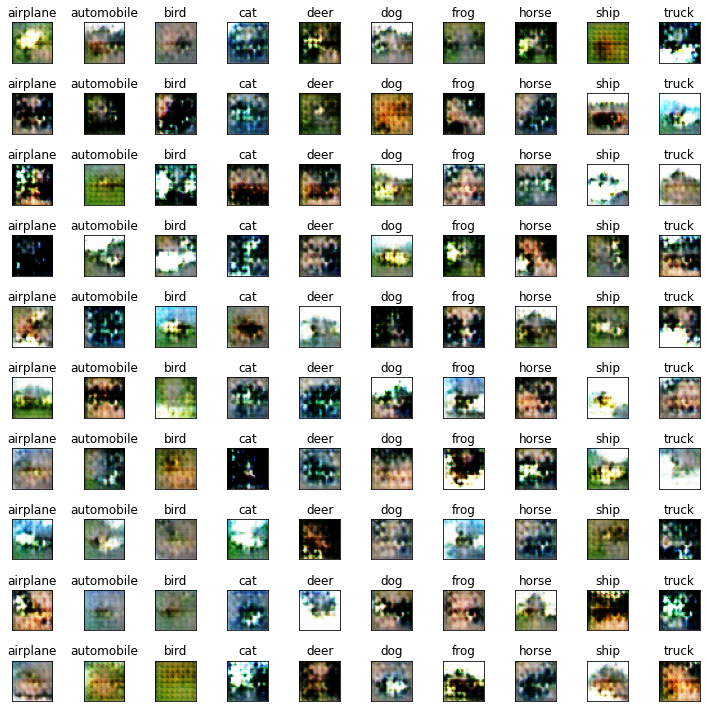

epoch = 2/30, d_loss=0.933, g_loss=7.371                                                                                                     
epoch = 3/30, d_loss=0.320, g_loss=3.514                                                                                                     
epoch = 4/30, d_loss=0.470, g_loss=3.659                                                                                                     
epoch = 5/30, d_loss=0.238, g_loss=3.130                                                                                                     
epoch = 6/30, d_loss=0.303, g_loss=4.338                                                                                                     


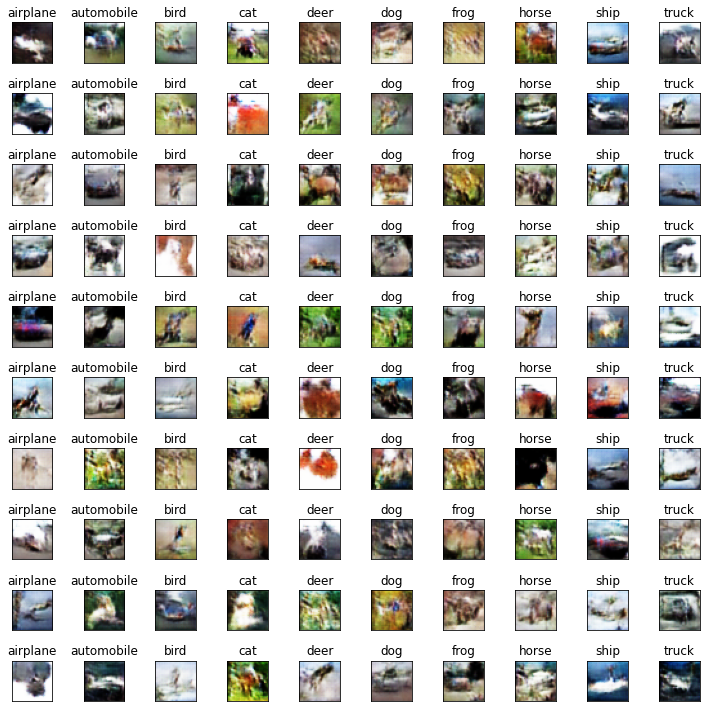

epoch = 7/30, d_loss=0.251, g_loss=4.014                                                                                                     
epoch = 8/30, d_loss=0.445, g_loss=1.165                                                                                                     
epoch = 9/30, d_loss=0.259, g_loss=6.870                                                                                                     
epoch = 10/30, d_loss=0.294, g_loss=1.644                                                                                                     
epoch = 11/30, d_loss=0.411, g_loss=2.125                                                                                                     


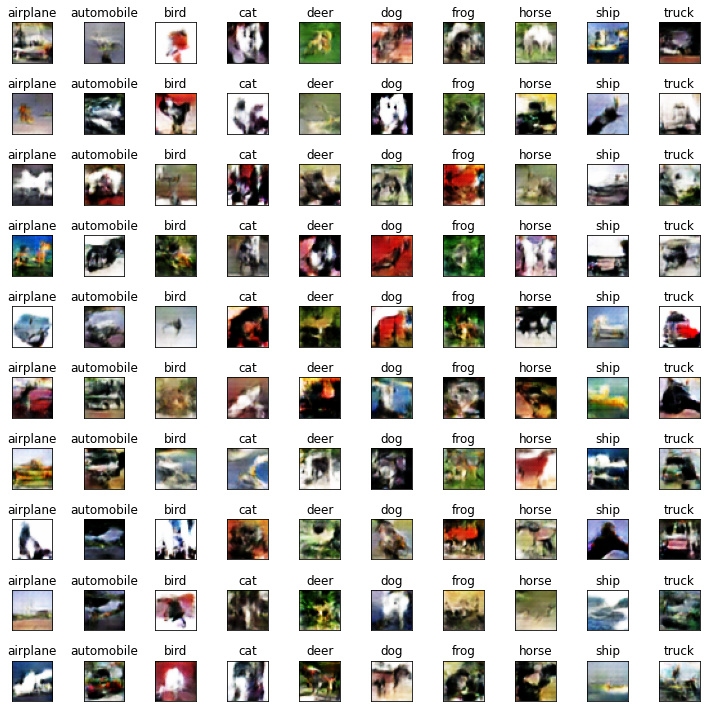

epoch = 12/30, d_loss=0.503, g_loss=7.611                                                                                                     
epoch = 13/30, d_loss=0.171, g_loss=1.489                                                                                                     
epoch = 14/30, d_loss=0.248, g_loss=5.385                                                                                                     
epoch = 15/30, d_loss=0.174, g_loss=1.334                                                                                                     
epoch = 16/30, d_loss=0.168, g_loss=1.737                                                                                                     


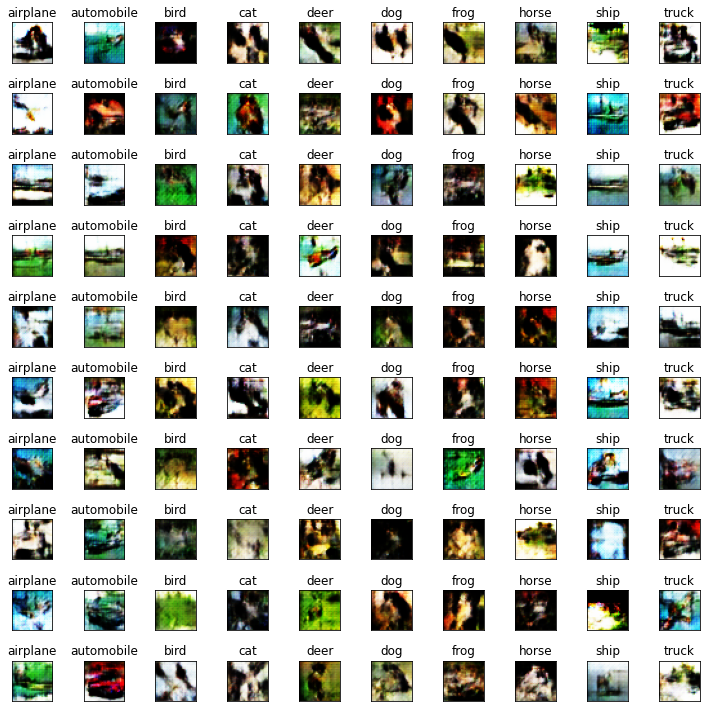

epoch = 17/30, d_loss=0.167, g_loss=2.692                                                                                                     
epoch = 18/30, d_loss=0.169, g_loss=0.305                                                                                                     
epoch = 19/30, d_loss=0.177, g_loss=0.703                                                                                                     
epoch = 20/30, d_loss=0.172, g_loss=9.151                                                                                                     
epoch = 21/30, d_loss=0.171, g_loss=0.205                                                                                                     


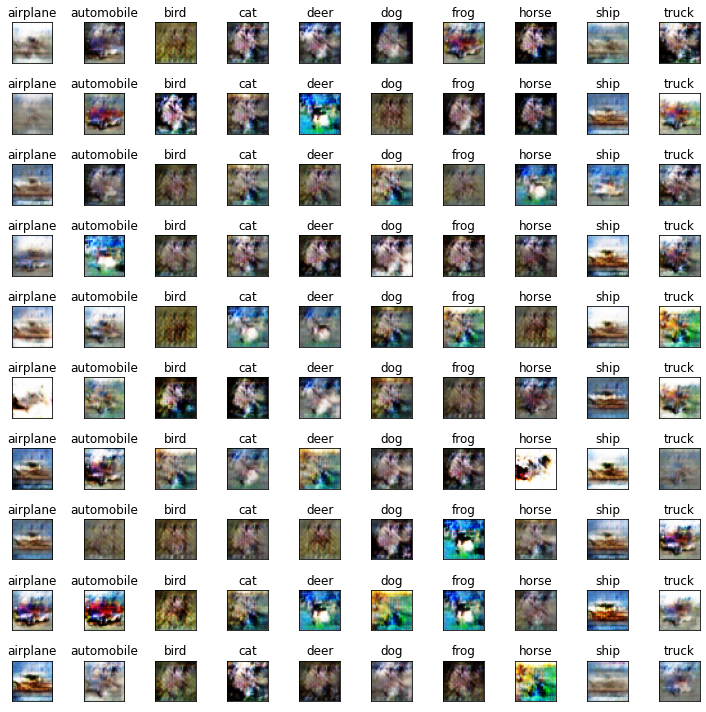

epoch = 22/30, d_loss=0.171, g_loss=11.024                                                                                                     
epoch = 23/30, d_loss=0.188, g_loss=9.480                                                                                                     
epoch = 24/30, d_loss=0.206, g_loss=4.897                                                                                                     
epoch = 25/30, d_loss=0.176, g_loss=7.685                                                                                                     
epoch = 26/30, d_loss=0.218, g_loss=5.632                                                                                                     


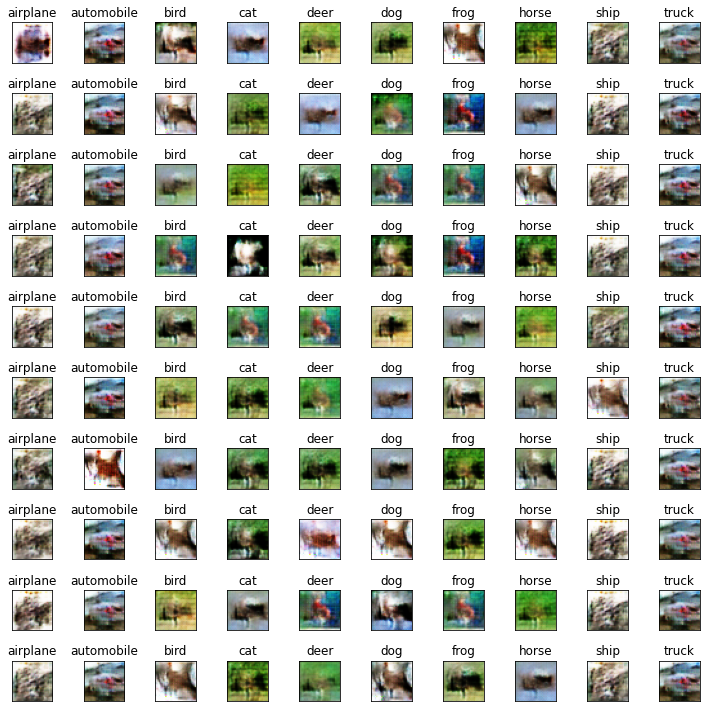

epoch = 27/30, d_loss=0.225, g_loss=9.686                                                                                                     
epoch = 28/30, d_loss=0.174, g_loss=8.137                                                                                                     
epoch = 29/30, d_loss=0.191, g_loss=23.160                                                                                                     
epoch = 30/30, d_loss=0.281, g_loss=29.398                                                                                                     


In [217]:
epochs = 30
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
     
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 5 == 0:
        num_of_sample = 0
        plt.figure(figsize = (10, 10))
        gs1 = gridspec.GridSpec(10, 10)
        gs1.update(wspace=0.0025, hspace=0.005)
        for m in range(10):
          samples = 10
          z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
          labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
          x_fake = generator.predict([z, labels])
          x_fake = np.clip(x_fake, -1, 1)
          x_fake = (x_fake + 1) * 127
          x_fake = np.round(x_fake).astype('uint8')
          
        
          for k in range(samples):
            plt.subplot(10, 10, num_of_sample + 1, xticks=[], yticks=[]) 
            plt.imshow(x_fake[k])
            plt.title(class_names[k])
            num_of_sample += 1
        plt.tight_layout()
        plt.show()

# Evaluate model

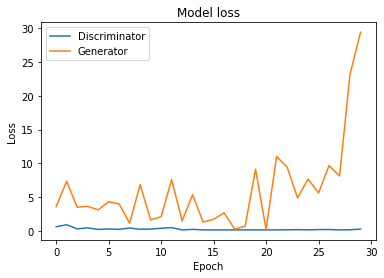

In [220]:
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='upper left')
plt.show()